In [1]:
import os, os.path
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from collections import deque
import itertools
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
import tensorflow.keras.losses as kls
from libs.utils import *
from libs.generate_boxes import *
from libs.dqn import *

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf_device='/gpu:0'
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()

'float32'

In [3]:
num_episode = 1500
global_step = 0
tr_l, h_fill, tr_r, avg_loss_l,history_eps,used_boxes_eps  = [],[],[],[],[],[]
N_MDD = 7
K = 4
n_candidates =4

In [4]:
boxes_multi1 = [np.array([[20, 20,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20, 20,  4],
         [20, 20,  4],
         [20, 20,  4]])]
gt_pos1 = [np.array([[ 0,  0,  0],
         [ 0,  0,  4],
         [ 0,  4,  4],
         [ 0,  8,  4],
         [ 0, 12,  4],
         [ 0, 16,  4],
         [ 0,  0,  8],
         [ 0,  0, 12],
         [ 0,  0, 16]])]

boxes_multi2 = [np.array([[20, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [10, 20,  5],
        [10, 20,  5],
        [20, 20,  5]])]

gt_pos2 = [np.array([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 4,  0,  5],
        [ 8,  0,  5],
        [12,  0,  5],
        [16,  0,  5],
        [ 0,  0, 10],
        [10,  0, 10],
        [ 0,  0, 15]])]

In [5]:
num_max_boxes = max(len(boxes_multi1[0]), len(boxes_multi2[0]))
num_max_remain = num_max_boxes
print('num_max_boxes',num_max_boxes,'num_max_remain',num_max_remain)

num_max_boxes 9 num_max_remain 9


In [36]:
env=Bpp3DEnv()

In [7]:
class PPO_Actor(tf.keras.Model):
    def __init__(self, state_size, selected_size, remain_size, loading_size, output_size):
        super(PPO_Actor, self).__init__()
        
        l1, b1, k1 = state_size
        self.state_size = (l1*b1*k1,)
        self.case_dnn1 = Dense(64, activation='relu', input_shape=self.state_size)
        self.case_dnn2 = Dense(64, activation='relu')
        
        l2, b2, k2 = selected_size
        self.selected_size = (l2*b2*k2,)
        self.select_dnn1 = Dense(64, activation='relu', input_shape=self.selected_size)
        self.select_dnn2 = Dense(64, activation='relu')
        
        l3, b3, k3 = remain_size
        self.remain_size = (l3*b3*k3,)
        self.remain_dnn1 = Dense(128, activation='relu', input_shape=self.remain_size)
        self.remain_dnn2 = Dense(128, activation='relu')
        
        l4, b4, k4 = loading_size
        self.loading_size = (l4*b4*k4,)
        self.loading_dnn1 = Dense(128, activation='relu', input_shape=self.loading_size)
        self.loading_dnn2 = Dense(128, activation='relu')
        
        self.fc1 = Dense(256, activation='relu')
        self.fc2 = Dense(128, activation='relu')
        self.fc_out = Dense(output_size)
        
    def call(self, cb_list):
        c,s,r,l = cb_list[0], cb_list[1], cb_list[2], cb_list[3]
        c = tf.reshape(c, [-1, self.state_size[0]])
        s = tf.reshape(s, [-1, self.selected_size[0]])
        r = tf.reshape(r, [-1, self.remain_size[0]])
        l = tf.reshape(l, [-1, self.loading_size[0]])
        
        c = self.case_dnn1(c)
        c = self.case_dnn2(c)
        
        s = self.select_dnn1(s)
        s = self.select_dnn2(s)
        
        r = self.remain_dnn1(r)
        r = self.remain_dnn2(r)
        
        l = self.loading_dnn1(l)
        l = self.loading_dnn2(l)
        
        x = concatenate([c,s,r,l])
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q

In [8]:
class PPO_Critic(tf.keras.Model):
    def __init__(self, state_size, selected_size, remain_size, loading_size, output_size):
        super(PPO_Critic, self).__init__()
        
        l1, b1, k1 = state_size
        self.state_size = (l1*b1*k1,)
        self.case_dnn1 = Dense(64, activation='relu', input_shape=self.state_size)
        self.case_dnn2 = Dense(64, activation='relu')
        
        l2, b2, k2 = selected_size
        self.selected_size = (l2*b2*k2,)
        self.select_dnn1 = Dense(64, activation='relu', input_shape=self.selected_size)
        self.select_dnn2 = Dense(64, activation='relu')
        
        l3, b3, k3 = remain_size
        self.remain_size = (l3*b3*k3,)
        self.remain_dnn1 = Dense(128, activation='relu', input_shape=self.remain_size)
        self.remain_dnn2 = Dense(128, activation='relu')
        
        l4, b4, k4 = loading_size
        self.loading_size = (l4*b4*k4,)
        self.loading_dnn1 = Dense(128, activation='relu', input_shape=self.loading_size)
        self.loading_dnn2 = Dense(128, activation='relu')
        
        self.fc1 = Dense(256, activation='relu')
        self.fc2 = Dense(128, activation='relu')
        self.fc_out = Dense(output_size)
        
    def call(self, cb_list):
        c,s,r,l = cb_list[0], cb_list[1], cb_list[2], cb_list[3]
        c = tf.reshape(c, [-1, self.state_size[0]])
        s = tf.reshape(s, [-1, self.selected_size[0]])
        r = tf.reshape(r, [-1, self.remain_size[0]])
        l = tf.reshape(l, [-1, self.loading_size[0]])
        
        c = self.case_dnn1(c)
        c = self.case_dnn2(c)
        
        s = self.select_dnn1(s)
        s = self.select_dnn2(s)
        
        r = self.remain_dnn1(r)
        r = self.remain_dnn2(r)
        
        l = self.loading_dnn1(l)
        l = self.loading_dnn2(l)
        
        x = concatenate([c,s,r,l])
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q

In [9]:
class PPOAgent():
    def __init__(self, L=20, B=20, H=20, n_remains=5, n_loading=3, lr=1e-8, train_st = 200):
        self.state_size = (L,B,1)
        self.selected_size = (L,B,2)
        self.remain_size=(L,B,n_remains)
        self.loading_size=(L,B,n_loading)
        self.output_size=1
        
        self.discount_factor=0.99
        self.gamma = 0.9
        self.clip_pram = 0.2
        self.learning_rate=lr
        
        self.train_st = train_st
        self.train_cnt = 0
        
        self.actor = PPO_Actor(self.state_size, self.selected_size, self.remain_size, self.loading_size, self.output_size)
        self.critic = PPO_Critic(self.state_size, self.selected_size, self.remain_size, self.loading_size, self.output_size)
        
        self.actor_optimizer = Adam(self.learning_rate)
        self.critic_optimizer = Adam(self.learning_rate)
        
        self.avg_actor_loss = 0
        self.avg_critic_loss = 0
        
    def get_action(self, state, loaded_mh_c, r_boxes, loading):
        self.train_cnt += 1
        if self.train_cnt < self.train_st:
            probs = self.actor([state, loaded_mh_c, r_boxes, loading])
            random_action = random.randrange(len(state))
            return probs[random_action], random_action
        else:
            probs = self.actor([state, loaded_mh_c, r_boxes, loading])
            argmax_idx = np.where(probs == tf.math.reduce_max(probs))
            action_idx = argmax_idx[0][0]
            return probs[action_idx], action_idx
        
    def get_value(self, state, loaded_mh_c, r_boxes, loading):
        value = self.critic([state, loaded_mh_c, r_boxes, loading])
        argmax_idx = np.where(value == tf.math.reduce_max(value))
        value = argmax_idx[0][0]
        return value
    
    def get_actor_loss(self, probs, advantage, old_probs, critic_loss):
        probability = probs
        entropy = tf.reduce_mean(tf.math.negative(tf.math.multiply(probability, tf.math.log(probability))))
        entropy = tf.math.abs(entropy) #삭제 가능하도록
        sr1, sr2 = [], []

        for prob, adv, old_prob in zip(probability, advantage, old_probs):
            adv = tf.constant(adv)
            old_prob = tf.constant(old_prob)
            ratio = tf.math.divide(prob, old_prob)
            adv = tf.cast(adv, dtype='float32')
            s1 = tf.math.multiply(ratio, adv)
            s2 = tf.math.multiply(tf.clip_by_value(ratio, 1.0-self.clip_pram, 1.0 + self.clip_pram), adv)
            sr1.append(s1)
            sr2.append(s2)
        sr1 = tf.stack(sr1)
        sr2 = tf.stack(sr2)
        act_loss = tf.math.negative(tf.reduce_mean(tf.math.minimum(sr1, sr2)) - critic_loss + 0.001 * entropy)
        return act_loss
    
    def train(self, state, loaded_mh_c, r_boxes, loaded, returns, adv, probs):
        discnt_rewards = tf.reshape(returns, (len(returns),))
        adv = tf.reshape(adv, (len(adv),))
        old_probs = probs
        old_probs = tf.reshape(old_probs, (len(old_probs),1))
        old_probs = tf.math.abs(old_probs) #삭제 가능하도록
        
        state = np.array(state)
        loaded_mh_c = np.array(loaded_mh_c)
        r_boxes = np.array(r_boxes)
        loaded = np.array(loaded)
        
        with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
            prob = self.actor([state, loaded_mh_c, r_boxes, loaded])
            prob = tf.math.abs(prob) #삭제 가능하도록
            value = self.critic([state, loaded_mh_c, r_boxes, loaded])
            value = tf.reshape(value, (len(value),))
            critic_loss = 0.5 * kls.mean_squared_error(discnt_rewards, value)
            actor_loss = self.get_actor_loss(prob, adv, old_probs, critic_loss)
            self.avg_actor_loss += actor_loss.numpy()
            self.avg_critic_loss += critic_loss.numpy()
                
        actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

In [37]:
agent = PPOAgent(L=20, B=20, H=20, n_remains=num_max_remain, n_loading=K, lr=1e-4, train_st = 200)

In [11]:
 def terminal_rewards(state, gamma, reward):
    terminal_rewards = []
    for i in range(len(state)):
        rewards = (gamma ** (len(state) - i - 1)) * reward
        terminal_rewards.append(rewards)
    return terminal_rewards

In [12]:
def get_discnt_reward(rewards, values, next_values, done):
    g = 0
    lmbda = 0.95
    gamma = 0.99
    returns = []
    
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * next_values[i] * dones[i] - values[i]
        g = delta + gamma * lmbda * dones[i] * g
        returns.append(g + values[i])
    returns.reverse()
    return returns

In [40]:
def get_advantage(returns, values):
    advantage = np.array(returns) - values
    print(advantage, np.mean(advantage), np.std(advantage))
    advantage = (advantage - np.mean(advantage)) / (np.std(advantage))
    return advantage

In [14]:
avg_actor_loss_l, avg_critic_loss_l = [], []

In [38]:
for e in range(1,num_episode):
    st = time.time()
    
    if e%2 == 1: boxes_multi,gt_pos = boxes_multi1.copy(), gt_pos1.copy()
    else: boxes_multi,gt_pos = boxes_multi2.copy(), gt_pos2.copy()
        
    env.reset()
    done = False
    step = 0
    
    history, h_load, h_remain_size, h_load_size = [],[],[],[]
    values, prob_l, dones, next_values = [],[],[],[]
    used_boxes, pred_pos = [],[]
    
    boxes_all = np.array(boxes_multi)[0].copy()
    r_boxes = boxes_all.copy()
    
    while not done:
        state = env.container_s.copy()
        state_h = env.container_h.copy()
        step += 1
        
        k = min(K, len(r_boxes))
        selected = cbn_select_boxes(r_boxes[:n_candidates], k)
        s_order = get_selected_order(selected, k)
        
        num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, state, state_h, env.height)
        in_state, in_r_boxes, in_loading = raw2input(state_h, len(num_loaded_c), r_boxes, num_max_remain, K, loading_size_c, env.height)
        
#         if len(num_loaded_c) == 1:
#             action_idx = 0
#         else:
        prob, action_idx = agent.get_action(in_state, np.array(loaded_mh_c), in_r_boxes, in_loading)
        value = agent.get_value(in_state, loaded_mh_c, in_r_boxes, in_loading)
        prob_l.append(prob)
        values.append(value)
            
        env.step(next_state_c[action_idx], next_h_c[action_idx])
        num_loaded_box = num_loaded_c[action_idx]
        
        if num_loaded_box != 0:
            new_used_boxes = loading_size_c[action_idx]
            r_boxes = get_remain(new_used_boxes, r_boxes)
            used_boxes = used_boxes + loading_size_c[action_idx]
            pred_pos = pred_pos + loading_pos_c[action_idx]
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
            
        if len(r_boxes) == 0 or np.sum(env.container_h != env.height) == 0:
            done = True
            
        if len(num_loaded_c) != 1 or done:
            dones.append(done)
            history.append(in_state[action_idx])
            h_load.append(loaded_mh_c[action_idx])
            h_remain_size.append(in_r_boxes[action_idx])
            h_load_size.append(in_loading[action_idx])
            
            next_state = next_state_c[action_idx].copy()
            next_state_h = next_h_c[action_idx].copy()
            
            if done:
                in_next_history = next_state_h.reshape((1, env.length, env.breadth, 1))
                loaded_mh_c = np.zeros((1, env.length, env.breadth, 2))
                in_next_remains = np.zeros((1, env.length, env.breadth, num_max_remain))
                in_next_loading = np.zeros((1, env.length, env.breadth, K))
            else:
                k = min(K, len(r_boxes))
                selected = cbn_select_boxes(r_boxes[:n_candidates], k)
                s_order = get_selected_order(selected, k)
                num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, next_state, next_state_h, env.height)
                in_next_history, in_next_remains, in_next_loading = \
                    raw2input(next_state_h, len(num_loaded_c), r_boxes, num_max_remain,  K, loading_size_c, env.height)
                
            next_value = agent.get_value(in_next_history, loaded_mh_c,
                                        in_next_remains, in_next_loading)
            next_values.append(next_value)
            
        if done:
            h_fill.append(env.terminal_reward())
            rewards = terminal_rewards(history, agent.discount_factor, env.terminal_reward()**3)
            
            returns = get_discnt_reward(rewards, values, next_values, dones)
            advantage = get_advantage(returns, values)
            
            probs = np.stack(prob_l, axis=0)
            
            agent.train(history, h_load, h_remain_size, h_load_size, returns, advantage, probs)
            avg_actor_loss_l.append(agent.avg_actor_loss)
            avg_critic_loss_l.append(agent.avg_critic_loss)
            
    log = "=====episode: {:5d} | ".format(e)
    log += "reward : {:.3f}| ".format(env.terminal_reward())
    log += "actor loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "critic loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    
    agent.avg_actor_loss, agent.avg_critic_loss = 0, 0

=====episode:     1 | reward : 0.800| actor loss : 0.066621 critic loss : 0.066748 time: 0.170
=====episode:     2 | reward : 0.750| actor loss : 0.043625 critic loss : 0.043753 time: 0.090
=====episode:     3 | reward : 0.800| actor loss : 0.029136 critic loss : 0.029222 time: 0.107
=====episode:     4 | reward : 0.750| actor loss : 0.011232 critic loss : 0.011325 time: 0.111
=====episode:     5 | reward : 0.800| actor loss : 0.008369 critic loss : 0.008476 time: 0.093
=====episode:     6 | reward : 0.750| actor loss : 0.002281 critic loss : 0.002392 time: 0.111
=====episode:     7 | reward : 0.800| actor loss : 0.000643 critic loss : 0.000770 time: 0.088
=====episode:     8 | reward : 0.750| actor loss : 0.000780 critic loss : 0.000864 time: 0.110
=====episode:     9 | reward : 0.800| actor loss : 0.000893 critic loss : 0.000999 time: 0.090
=====episode:    10 | reward : 0.750| actor loss : 0.018116 critic loss : 0.018221 time: 0.093
=====episode:    11 | reward : 0.720| actor loss :

KeyboardInterrupt: 

In [42]:
for e in range(1,num_episode):
    st = time.time()
    
    boxes_multi,gt_pos = generation_3dbox(case_size=[[20,20,20]], min_s = 1, N_mdd=N_MDD, is_prediv='h')
    
    #if e%2 == 1: boxes_multi,gt_pos = boxes_multi1.copy(), gt_pos1.copy()
    #else: boxes_multi,gt_pos = boxes_multi2.copy(), gt_pos2.copy()
        
    env.reset()
    done = False
    step = 0
    
    history, h_load, h_remain_size, h_load_size = [],[],[],[]
    values, prob_l, dones, next_values = [],[],[],[]
    used_boxes, pred_pos = [],[]
    
    boxes_all = np.array(boxes_multi)[0].copy()
    r_boxes = boxes_all.copy()
    
    while not done:
        state = env.container_s.copy()
        state_h = env.container_h.copy()
        step += 1
        
        k = min(K, len(r_boxes))
        selected = cbn_select_boxes(r_boxes[:n_candidates], k)
        s_order = get_selected_order(selected, k)
        
        num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, state, state_h, env.height)
        in_state, in_r_boxes, in_loading = raw2input(state_h, len(num_loaded_c), r_boxes, num_max_remain, K, loading_size_c, env.height)
        
        if len(num_loaded_c) == 1:
            action_idx = 0
        else:
            prob, action_idx = agent.get_action(in_state, np.array(loaded_mh_c), in_r_boxes, in_loading)
            value = agent.get_value(in_state, loaded_mh_c, in_r_boxes, in_loading)
            prob_l.append(prob)
            values.append(value)
            
        env.step(next_state_c[action_idx], next_h_c[action_idx])
        num_loaded_box = num_loaded_c[action_idx]
        
        if num_loaded_box != 0:
            new_used_boxes = loading_size_c[action_idx]
            r_boxes = get_remain(new_used_boxes, r_boxes)
            used_boxes = used_boxes + loading_size_c[action_idx]
            pred_pos = pred_pos + loading_pos_c[action_idx]
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
            
        if len(r_boxes) == 0 or np.sum(env.container_h != env.height) == 0:
            done = True
            
        if len(num_loaded_c) != 1 or done:
            dones.append(done)
            history.append(in_state[action_idx])
            h_load.append(loaded_mh_c[action_idx])
            h_remain_size.append(in_r_boxes[action_idx])
            h_load_size.append(in_loading[action_idx])
            
            next_state = next_state_c[action_idx].copy()
            next_state_h = next_h_c[action_idx].copy()
            
            if done:
                in_next_history = next_state_h.reshape((1, env.length, env.breadth, 1))
                loaded_mh_c = np.zeros((1, env.length, env.breadth, 2))
                in_next_remains = np.zeros((1, env.length, env.breadth, num_max_remain))
                in_next_loading = np.zeros((1, env.length, env.breadth, K))
            else:
                k = min(K, len(r_boxes))
                selected = cbn_select_boxes(r_boxes[:n_candidates], k)
                s_order = get_selected_order(selected, k)
                num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, next_state, next_state_h, env.height)
                in_next_history, in_next_remains, in_next_loading = \
                    raw2input(next_state_h, len(num_loaded_c), r_boxes, num_max_remain,  K, loading_size_c, env.height)
                
            next_value = agent.get_value(in_next_history, loaded_mh_c,
                                        in_next_remains, in_next_loading)
            next_values.append(next_value)
            
        if done:
            h_fill.append(env.terminal_reward())
            rewards = terminal_rewards(history, agent.discount_factor, env.terminal_reward()**3)
            
            if len(values) < len(next_values):
                values.append(values[-1])
            
            returns = get_discnt_reward(rewards, values, next_values, dones)
            advantage = get_advantage(returns, values)
            print(len(advantage))
            
            probs = np.stack(prob_l, axis=0)
            
            #print(probs)
            #print(advantage)
            #print(returns)
            
            agent.train(history, h_load, h_remain_size, h_load_size, returns, advantage, probs)
            avg_actor_loss_l.append(agent.avg_actor_loss)
            avg_critic_loss_l.append(agent.avg_critic_loss)
            
    log = "=====episode: {:5d} | ".format(e)
    log += "reward : {:.3f}| ".format(env.terminal_reward())
    log += "actor loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "critic loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    
    agent.avg_actor_loss, agent.avg_critic_loss = 0, 0

[-9.67858087] -9.678580875 0.0
1
=====episode:     1 | reward : 0.685| actor loss :    nan critic loss : 0.006599 time: 0.076


C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


ValueError: negative dimensions are not allowed

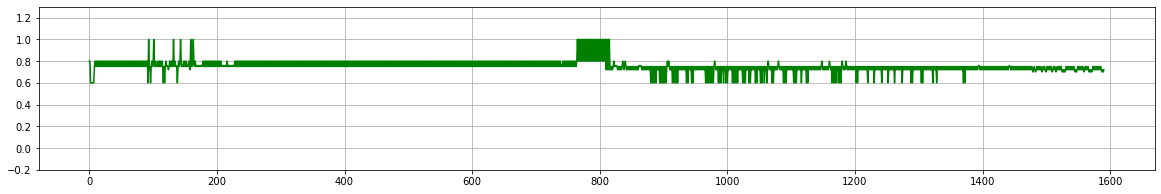

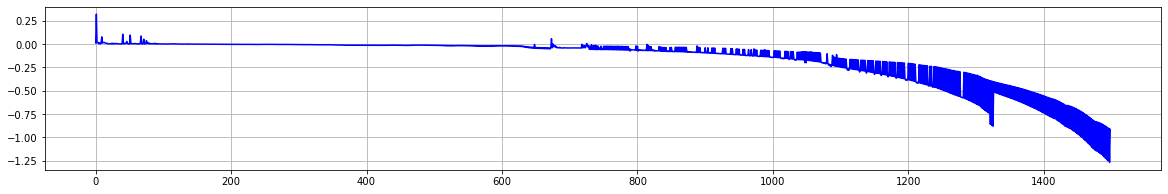

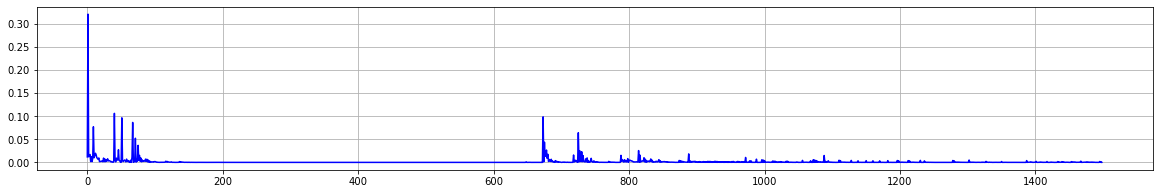

In [37]:
%matplotlib inline

plt.figure(figsize=(20,3))
plt.plot(h_fill,'g-')
plt.ylim(-0.2,1.3)
plt.grid()

plt.figure(figsize=(20,3))
plt.plot(avg_actor_loss_l,'b-')
plt.grid()
plt.show()

plt.figure(figsize=(20,3))
plt.plot(avg_critic_loss_l,'b-')
plt.grid()
plt.show()

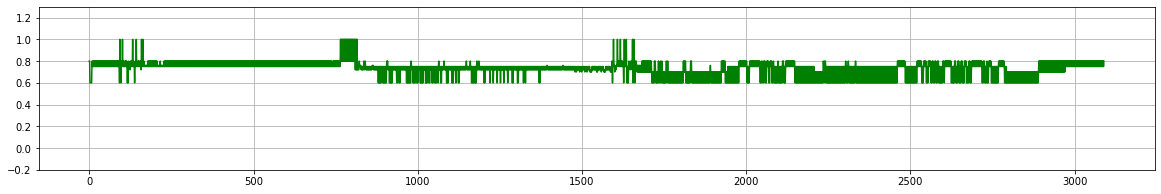

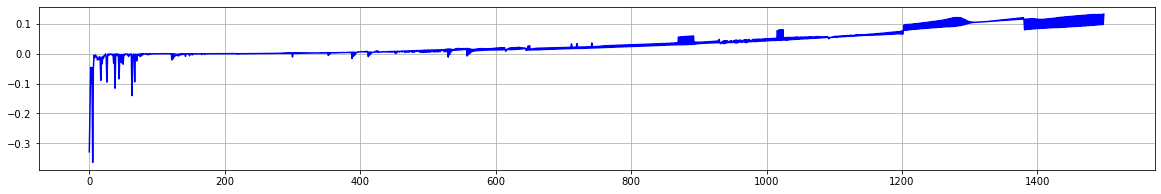

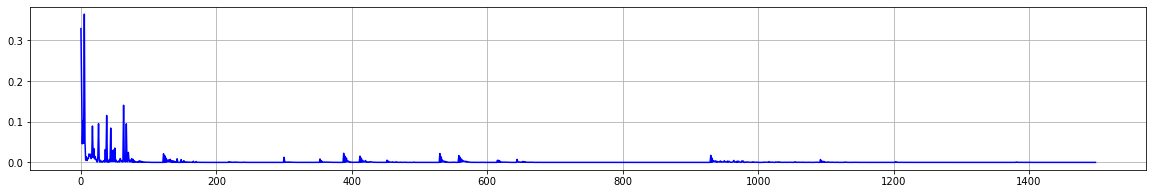

In [45]:
%matplotlib inline

plt.figure(figsize=(20,3))
plt.plot(h_fill,'g-')
plt.ylim(-0.2,1.3)
plt.grid()

plt.figure(figsize=(20,3))
plt.plot(avg_actor_loss_l,'b-')
plt.grid()
plt.show()

plt.figure(figsize=(20,3))
plt.plot(avg_critic_loss_l,'b-')
plt.grid()
plt.show()